In [1]:
import pandas as pd
import numpy as np
import os
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [2]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt

In [3]:
from tensorflow.keras.callbacks import Callback

In [4]:
# Set paths for CSV and image directories
train_csv = '/content/drive/MyDrive/cars_train.csv'
test_csv = '/content/drive/MyDrive/cars_test.csv'
train_img_dir = '/content/drive/MyDrive/cars_train_images - Copy'
test_img_dir = '/content/drive/MyDrive/cars_test_images - Copy'
#train_img_dir = '/content/drive/MyDrive/cars_train_images'
#test_img_dir = '/content/drive/MyDrive/cars_test_images'

In [5]:
# Load CSV data
train_df = pd.read_csv(train_csv)
test_df = pd.read_csv(test_csv)

In [6]:
def resize_and_pad_image(img, target_size):
    old_size = img.shape[:2]  # Get current image size (height, width)
    ratio = min(float(target_size[0]) / old_size[0], float(target_size[1]) / old_size[1])  # Maintain aspect ratio
    new_size = tuple([int(x * ratio) for x in old_size])  # New size after maintaining aspect ratio

    # Resize the image while keeping the aspect ratio
    resized_img = cv2.resize(img, (new_size[1], new_size[0]))

    # Create a new image of the target size (224, 224) and pad the resized image to fit it
    padded_img = np.zeros((target_size[0], target_size[1], 3), dtype=np.uint8)  # Create a black canvas

    # Compute padding
    pad_h = (target_size[0] - new_size[0]) // 2
    pad_w = (target_size[1] - new_size[1]) // 2

    # Place the resized image onto the padded canvas
    padded_img[pad_h:pad_h + new_size[0], pad_w:pad_w + new_size[1], :] = resized_img

    return padded_img


In [7]:
def load_images(df, img_dir, target_size=(224, 224)):
    images = []
    labels = []
    for index, row in df.iterrows():
        img_path = os.path.join(img_dir, row['image'])
        img = cv2.imread(img_path)
        if img is not None:
            # Crop the image based on the bounding box (x1, y1, x2, y2)
            x1, y1, x2, y2 = int(row['x1']), int(row['y1']), int(row['x2']), int(row['y2'])
            img = img[y1:y2, x1:x2]  # Crop the image
            img = resize_and_pad_image(img, target_size)  # Resize and pad the image
            images.append(img)
            labels.append(row['class'])  # Use 'class' for classification
    return np.array(images), np.array(labels)

In [8]:
test_df['image'] = test_df['image'].str.strip("'") #csv file for test have ''

In [9]:
# Load training and testing images
X_train, y_train = load_images(train_df, train_img_dir)
X_test, y_test = load_images(test_df, test_img_dir)

In [10]:
# Normalize images
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Encode labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

# Train/validation split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [11]:
# CNN model
def create_cnn_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [12]:
# Get input shape and number of classes
input_shape = X_train.shape[1:]  # (224, 224, 3)
num_classes = len(np.unique(y_train))

# Create model
model = create_cnn_model(input_shape, num_classes)

# Train the model
#history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:
# VALIDATION - Callback to track precision, recall, F1 during training
class MetricsCallback(tf.keras.callbacks.Callback):
    def __init__(self, validation_data):
        super(MetricsCallback, self).__init__()
        self.validation_data = validation_data

    def on_epoch_end(self, epoch, logs=None):
        # Predict on validation set
        X_val, y_val = self.validation_data
        y_val_pred = self.model.predict(X_val)
        y_val_pred_classes = np.argmax(y_val_pred, axis=1)

        # Calculate precision, recall, and F1 score
        precision = precision_score(y_val, y_val_pred_classes, average='weighted')
        recall = recall_score(y_val, y_val_pred_classes, average='weighted')
        f1 = f1_score(y_val, y_val_pred_classes, average='weighted')

        # Log metrics
        print(f' — val_precision: {precision:.4f} — val_recall: {recall:.4f} — val_f1: {f1:.4f}')

# Pass validation data when initializing MetricsCallback
metrics_callback = MetricsCallback(validation_data=(X_val, y_val))

In [14]:
# train model with validation metrics
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[metrics_callback])

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
 — val_precision: 0.0000 — val_recall: 0.0037 — val_f1: 0.0000
100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step - accuracy: 0.0040 - loss: 5.3911 - val_accuracy: 0.0037 - val_loss: 5.2792
Epoch 2/10
  9/100 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.0043 - loss: 5.2761

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
 — val_precision: 0.0002 — val_recall: 0.0050 — val_f1: 0.0004
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.0054 - loss: 5.2745 - val_accuracy: 0.0050 - val_loss: 5.2729
Epoch 3/10
 10/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.0087 - loss: 5.2558

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
 — val_precision: 0.0008 — val_recall: 0.0075 — val_f1: 0.0013
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.0085 - loss: 5.2360 - val_accuracy: 0.0075 - val_loss: 5.2597
Epoch 4/10
 11/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.0180 - loss: 5.1390

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
 — val_precision: 0.0026 — val_recall: 0.0063 — val_f1: 0.0034
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.0137 - loss: 5.1464 - val_accuracy: 0.0063 - val_loss: 5.2918
Epoch 5/10
 11/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.0314 - loss: 5.0393

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
 — val_precision: 0.0087 — val_recall: 0.0125 — val_f1: 0.0081
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.0315 - loss: 4.9613 - val_accuracy: 0.0125 - val_loss: 5.2862
Epoch 6/10
 11/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.0289 - loss: 4.7204

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
 — val_precision: 0.0115 — val_recall: 0.0163 — val_f1: 0.0108
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.0596 - loss: 4.6176 - val_accuracy: 0.0162 - val_loss: 5.3762
Epoch 7/10
 11/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.1429 - loss: 4.1804

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
 — val_precision: 0.0203 — val_recall: 0.0187 — val_f1: 0.0165
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.1295 - loss: 4.1401 - val_accuracy: 0.0188 - val_loss: 5.4283
Epoch 8/10
 11/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.1577 - loss: 3.7822

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
 — val_precision: 0.0063 — val_recall: 0.0112 — val_f1: 0.0071
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.1708 - loss: 3.7160 - val_accuracy: 0.0113 - val_loss: 5.5486
Epoch 9/10
 10/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.2530 - loss: 3.3332

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
 — val_precision: 0.0157 — val_recall: 0.0213 — val_f1: 0.0160
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.2396 - loss: 3.2840 - val_accuracy: 0.0213 - val_loss: 6.0339
Epoch 10/10
 11/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.2899 - loss: 2.9166

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
 — val_precision: 0.0171 — val_recall: 0.0175 — val_f1: 0.0155
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.2784 - loss: 2.9627 - val_accuracy: 0.0175 - val_loss: 6.0518


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [15]:
# TRAINING METRICS

# Calculate precision, recall, and F1-score for the training set
y_train_pred = model.predict(X_train)
y_train_pred_classes = np.argmax(y_train_pred, axis=1)

100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


In [16]:


train_precision = precision_score(y_train, y_train_pred_classes, average='weighted')
train_recall = recall_score(y_train, y_train_pred_classes, average='weighted')
train_f1 = f1_score(y_train, y_train_pred_classes, average='weighted')

print(f'Train Precision: {train_precision:.4f}')
print(f'Train Recall: {train_recall:.4f}')
print(f'Train F1-Score: {train_f1:.4f}')

Train Precision: 0.7881
Train Recall: 0.7638
Train F1-Score: 0.7615


In [17]:
train_loss, train_acc = model.evaluate(X_train, y_train)
print(f'Training accuracy: {train_acc:.4f}')

100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7548 - loss: 1.5019
Training accuracy: 0.7638


In [18]:
print(f"Number of test images loaded: {len(X_test)}")
print(f"Number of test labels loaded: {len(y_test)}")

Number of test images loaded: 4000
Number of test labels loaded: 4000


In [19]:
#print(train_df.head())

In [20]:

# debugging
print(f"X_test shape: {X_test.shape}")  # Should be (num_samples, 224, 224, 3)
print(f"y_test shape: {y_test.shape}")  # Should be (num_samples,) or one-hot encoded, depending on your label format

X_test shape: (4000, 224, 224, 3)
y_test shape: (4000,)


In [21]:
# debugging - evaluate on a batch

#test_loss, test_acc = model.evaluate(X_test[:32], y_test[:32])
#print(f'Test accuracy: {test_acc:.4f}')

In [22]:
# Evaluate on test data
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc:.4f}')

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.0220 - loss: 6.1264
Test accuracy: 0.0190


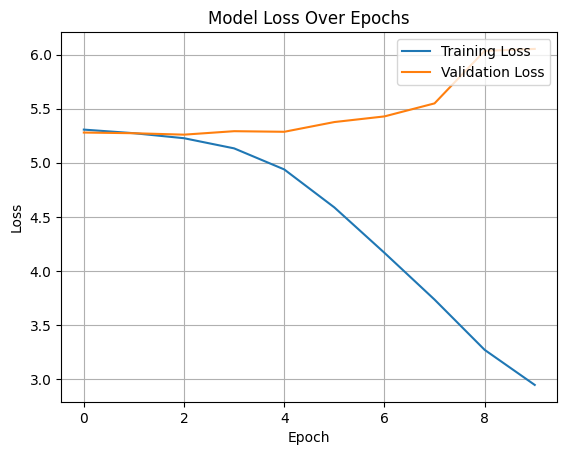

In [23]:
# Plotting loss curve

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [24]:
# classify a given image

def classify_image(image_path, model, target_size=(224, 224)):
    img = cv2.imread(image_path)
    img = resize_and_pad_image(img, target_size)
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    img = img.astype('float32') / 255.0  # Normalize

    prediction = model.predict(img)
    predicted_class = np.argmax(prediction, axis=1)  # Get the predicted class index
    class_label = label_encoder.inverse_transform(predicted_class)[0]  # Convert index to label
    return class_label, prediction

# Test the classifier with an image
#test_image_path = '/content/drive/MyDrive/cars_test_images - Copy/test_image.jpg'
#predicted_class, prediction = classify_image(test_image_path, model)
#print(f'Predicted Class: {predicted_class}')

In [25]:
# TESTING - Evaluate model performance

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

precision_testing = precision_score(y_test, y_pred_classes, average='weighted')
recall_testing = recall_score(y_test, y_pred_classes, average='weighted')
f1_testing = f1_score(y_test, y_pred_classes, average='weighted')

print(f'Precision: {precision_testing:.4f}')
print(f'Recall: {recall_testing:.4f}')
print(f'F1-Score: {f1_testing:.4f}')

# Print classification report for more details
target_names = [str(label) for label in label_encoder.classes_]
print(classification_report(y_test, y_pred_classes, target_names=target_names))


125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Precision: 0.0183
Recall: 0.0190
F1-Score: 0.0161
              precision    recall  f1-score   support

           1       0.07      0.10      0.08        30
           2       0.00      0.00      0.00        18
           3       0.00      0.00      0.00        18
           4       0.00      0.00      0.00        17
           5       0.00      0.00      0.00        22
           6       0.03      0.23      0.06        22
           7       0.00      0.00      0.00        21
           8       0.00      0.00      0.00        23
           9       0.00      0.00      0.00        20
          10       0.20      0.08      0.11        13
          11       0.05      0.04      0.04        23
          12       0.00      0.00      0.00        17
          13       0.00      0.00      0.00        21
          14       0.00      0.00      0.00        25
          15       0.00      0.00      0.00        20
          16       0.04      0.07      0.05 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

In [26]:
import pickle

model_filename = "cnn_car_model.pkl"
with open(model_filename, 'wb') as file:
    pickle.dump(model, file)

print(f"Model saved as {model_filename}")

Model saved as cnn_car_model.pkl
